### CLIP Feature Extraction

In [ ]:
# Import Libraries

# General
import gc
import os
import random
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Matrix Manipulation
import numpy as np
import pandas as pd

# Image Handling
from torchvision.transforms import transforms
from torchvision import transforms, datasets

# Dataset
import huggingface_hub
from datasets import load_dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Model Building
import clip
import torch
from torch import nn
import torch.optim as optim

# Random Seed
np.random.seed(0)

In [ ]:
# # HuggingFace Login to access the data
# huggingface_hub.notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-f559c639a48093b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


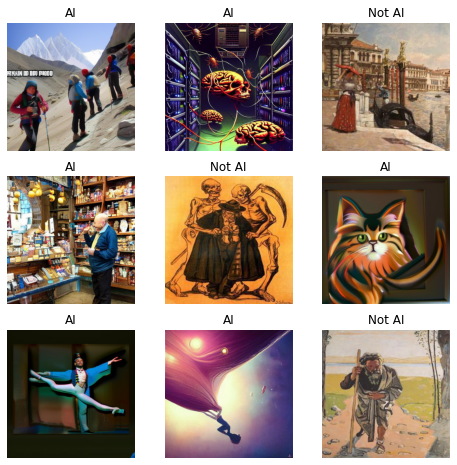

100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 195MiB/s]
  0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:308: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
100%|██████████| 37/37 [08:22<00:00, 13.57s/it]


In [ ]:
# Load Train Data
dataset = load_dataset('competitions/aiornot', split='train')

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    _, img, label = dataset[sample_idx].values()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# DataLoader to load data
BATCH_SIZE = 512

# Loading CLIP Model to extract features from the images
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
model.eval()

def collate_fn(data):
  return torch.stack([preprocess(x['image']) for x in data]), torch.tensor([x['label'] for x in data])
  
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# For Storing Extracted Features
image_features = list()
labels = list()

# Folder to save all extrated features
if not os.path.exists('Fatima-Fellowship-Challenge'):
  os.mkdir('Fatima-Fellowship-Challenge')
  os.mkdir('Fatima-Fellowship-Challenge/output')
  os.mkdir('Fatima-Fellowship-Challenge/label')
else:
  if not os.path.exists('Fatima-Fellowship-Challenge/output-clip'):
    os.mkdir('Fatima-Fellowship-Challenge/output-clip')
    os.mkdir('Fatima-Fellowship-Challenge/label-clip')


# Frees up GPU, when running inference in a loop, to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()

# Extract Features
idx = 0
for batch, label in tqdm(dataloader):
  
  # Moving the batch image tensor to cuda
  batch = batch.to('cuda')
  
  # CLIP Feature Extraction
  with torch.no_grad():
    output = model.encode_image(batch)
  
  # Saving Features
  torch.save(output, f'Fatima-Fellowship-Challenge/output-clip/{idx}.pt')
  torch.save(label, f'Fatima-Fellowship-Challenge/label-clip/{idx}.pt')
  idx += 1

  optimize_gpu()

# image_features = torch.concatenate(image_features)
# labels = torch.concatenate(labels)

In [ ]:
image_features = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/output-clip/{i}.pt' for i in range(37)]]
image_labels = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/label-clip/{i}.pt' for i in range(37)]]

In [ ]:
image_features = torch.concatenate(image_features)
image_labels = torch.concatenate(image_labels)

In [ ]:
BATCH_SIZE = 32
VAL_SIZE = 1000
traindataset = TensorDataset(image_features[:-VAL_SIZE], image_labels[:-VAL_SIZE])
trainloader = DataLoader(traindataset, BATCH_SIZE, True)
valdataset = TensorDataset(image_features[-VAL_SIZE:], image_labels[-VAL_SIZE:])
valloader = DataLoader(valdataset, 1000)

In [ ]:
classifier = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
classifier = classifier.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=0.9)

In [ ]:
NUM_EPOCHS = 150
train_loss = list()
val_loss = list()

for epoch in range(NUM_EPOCHS):

  running_loss = 0.0
  for i, data in enumerate(trainloader):

    inputs, labels = data

    inputs = inputs.cuda().float()
    labels = labels.cuda()

    optimizer.zero_grad()

    outputs = classifier(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      with torch.no_grad():
        inps, labs = next(iter(valloader))
        inps = inps.cuda().float()
        labs = labs.cuda()
        out = classifier(inps)
        val_los = criterion(out, labs).item()

      train_loss.append(running_loss)
      val_loss.append(val_los)

      print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss:.3f} | val_loss: {val_los:.3f}')
      running_loss = 0.0
            

print('Finished Training')

[1,   100] train_loss: 46.057 | val_loss: 0.307
[1,   200] train_loss: 25.895 | val_loss: 0.239
[1,   300] train_loss: 22.337 | val_loss: 0.206
[1,   400] train_loss: 19.780 | val_loss: 0.189
[1,   500] train_loss: 20.471 | val_loss: 0.175
[2,   100] train_loss: 16.955 | val_loss: 0.162
[2,   200] train_loss: 17.436 | val_loss: 0.167
[2,   300] train_loss: 16.836 | val_loss: 0.156
[2,   400] train_loss: 16.382 | val_loss: 0.154
[2,   500] train_loss: 16.258 | val_loss: 0.153
[3,   100] train_loss: 14.554 | val_loss: 0.152
[3,   200] train_loss: 14.391 | val_loss: 0.147
[3,   300] train_loss: 14.292 | val_loss: 0.149
[3,   400] train_loss: 15.699 | val_loss: 0.145
[3,   500] train_loss: 14.098 | val_loss: 0.144
[4,   100] train_loss: 13.629 | val_loss: 0.143
[4,   200] train_loss: 13.393 | val_loss: 0.146
[4,   300] train_loss: 13.931 | val_loss: 0.142
[4,   400] train_loss: 12.741 | val_loss: 0.140
[4,   500] train_loss: 14.162 | val_loss: 0.144
[5,   100] train_loss: 12.926 | val_loss

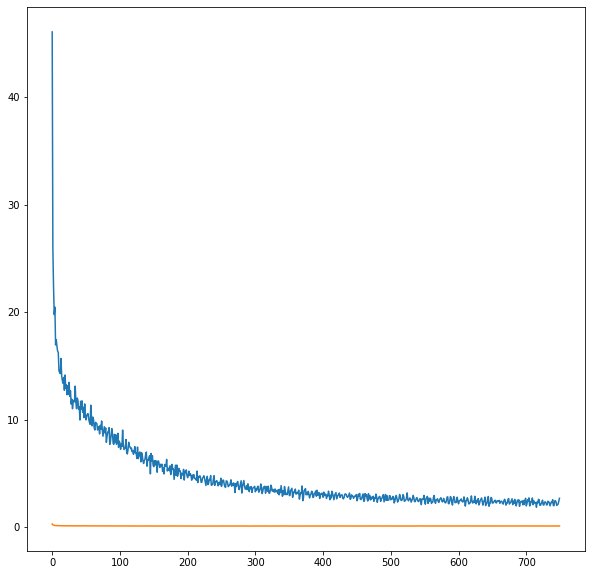

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
with torch.no_grad():
  pred_probs = classifier(next(iter(valloader))[0].float())

In [ ]:
preds = np.argmax(pred_probs.cpu(), 1)

In [ ]:
torch.sum(preds == next(iter(valloader))[1].cpu()) / len(valdataset)

tensor(0.9520)

In [ ]:
misclassified = list(((preds != next(iter(valloader))[1].cpu())).nonzero().squeeze().numpy())

In [ ]:
val_data = dataset[-VAL_SIZE:]

In [ ]:
random.randint(0, len(misclassified))

14

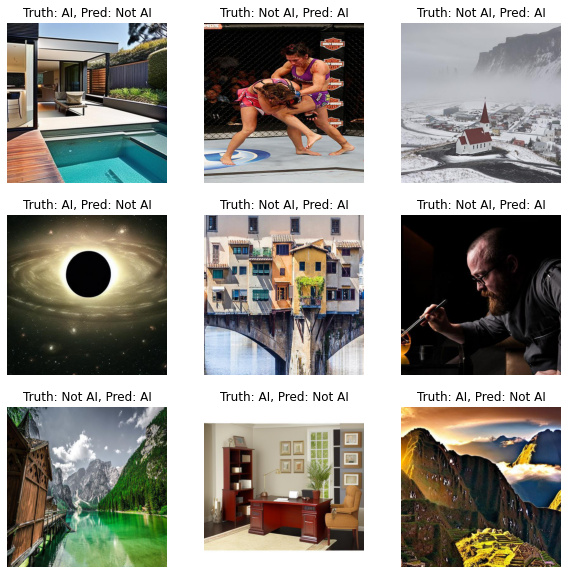

In [ ]:
# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = misclassified[random.randint(0, len(misclassified))]
    img, label = val_data['image'][sample_idx], val_data['label'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Truth: {labels_map[label]}, Pred: {labels_map[list(preds.numpy())[sample_idx]]}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()